In [695]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy.stats import norm
from sklearn.metrics import r2_score

In [696]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_juli.csv", sep=",")

In [697]:
df.dropna(inplace=True)

In [698]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [699]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [700]:
cutoffs = pd.date_range(
    start="2020-09-30",   # first end-of-month
    end="2021-08-31",     # last end-of-month
    freq="ME"              # month-end
).to_list()

In [701]:
###resultat valg 2021
valg = {
    "Ap": [26.3],
    "Høyre": [20.4],
    "Frp": [11.6],
    "SV": [7.6],
    "Sp": [13.5],
    "KrF": [3.8],
    "Venstre": [4.6],
    "MDG": [3.9],
    "Rødt": [4.7],
#    "Andre": [3.6],
}

###resultat valg 2017
#valg = {
#    "Ap": [27.4],
#    "Høyre": [25.0],
#    "Frp": [15.2],
#    "SV": [6.0],
#    "Sp": [10.3],
#    "KrF": [4.2],
#    "Venstre": [4.4],
#    "MDG": [3.2],
#    "Rødt": [2.4],
#    "Andre": [1.8],
#}



# Lage DataFrame
valg_df = pd.DataFrame(valg)
results = []
finals = []
y_true = valg_df.values.reshape(1, -1)[0]

In [702]:
parties= ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt']

In [703]:
for i, cutoff in enumerate(cutoffs):
    # Fit model on training set
    df_en=df[parties]

    df_ex = df[[c for c in df.columns if c not in df_en.columns and c not in ['Andre']]].iloc[1:]
        
    steps = len(cutoffs) - i +1

    ex_future=df_ex.loc[df_ex.index >= cutoff][:steps]
        
    df_en=df_en.loc[df_en.index <= cutoff]
    df_ex=df_ex.loc[df_ex.index <= cutoff]
            
    df_orig=df_en
    df_en_val = df_en.diff().dropna() 
            
    #print(ex_future)
    #print(cutoff)
    #model = VAR(df_en_val)
    model = VAR(endog=df_en_val, exog=df_ex)
    model_fitted = model.fit(maxlags=3, trend='n', method = 'ols')

    forecast_dates = pd.date_range(start=cutoff, periods=steps, freq='ME')
    
    last_actual_value = df_orig.iloc[-1]  # Last known actual data point
    #print(last_actual_value)
    forecast = model_fitted.forecast(df_en_val.values[-model_fitted.k_ar:], steps=steps,  exog_future=ex_future)
            
    forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en_val.columns)
    print(forecast_df)
    forecast_df = forecast_df.cumsum() + last_actual_value
    date_to_extract = "2021-09-30"
    estimate_row = forecast_df.loc[date_to_extract]
    y_pred = estimate_row.values.reshape(1, -1)[0]  
    #y_pred = (y_pred / y_pred.sum()) * 100

    # Compute error metric (MSE here)
    mse = median_absolute_error(y_true, y_pred)
    mse_pp = median_absolute_error(y_true, last_actual_value.values.reshape(1, -1)[0])
    
    results.append((cutoff,steps, mse, mse_pp))


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31

                  Ap     Hoyre       Frp        SV        SP       KrF  \
2020-09-30  1.893987 -0.819362 -0.813521 -0.413783 -0.170665  0.196682   
2020-10-31 -1.015879 -0.089144 -1.380059  0.339119  0.642758  0.167348   
2020-11-30 -0.530347 -0.724169 -1.360219  0.439562  0.170342  0.246597   
2020-12-31 -0.941718  0.109087 -0.351504  0.056464  0.303800 -0.025950   
2021-01-31 -1.092325  0.080280 -1.363693  0.182260  0.491303  0.183722   
2021-02-28 -0.824255 -0.079851 -1.290070  0.264904  0.141416  0.108687   
2021-03-31 -1.266648 -0.702345 -0.265465  0.046964  0.053721  0.279197   
2021-04-30 -1.906758  0.226995 -1.477406  0.225870  0.404149 -0.084431   
2021-05-31 -2.073819  0.642604 -1.044901  0.313497  0.084493  0.154083   
2021-06-30 -1.742811 -0.079431 -0.468656  0.344711  0.235757  0.364558   
2021-07-31 -0.586928 -1.344954  1.244541  0.383786 -0.189421  0.014471   
2021-08-31 -0.201131 -1.876385  0.559793  0.329914  0.292309  0.080691   
2021-09-30 -0.620555 -0.916578 -1.3059

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [704]:
y_pred

array([22.41780245, 19.59280773, 11.25547178,  9.9805565 , 14.28318787,
        3.14773041,  4.70666867,  5.78745198,  4.88827362])

In [705]:
results_df=pd.DataFrame(results, columns=["cutoff", "steps", "MSE", "mse_pp"])

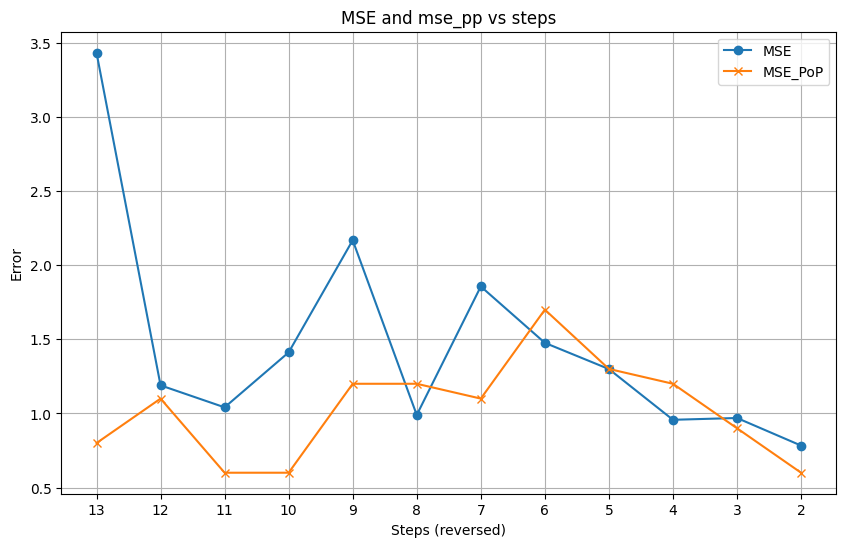

In [706]:
df_sorted = results_df.sort_values("steps", ascending=True)  # reverse lag order for x-axis
df_sorted
plt.figure(figsize=(10, 6))
plt.plot(df_sorted["steps"], df_sorted["MSE"], marker='o', label="MSE")
plt.plot(df_sorted["steps"], df_sorted["mse_pp"], marker='x', label="MSE_PoP")

plt.xlabel("Steps (reversed)")
plt.ylabel("Error")
plt.title("MSE and mse_pp vs steps")
plt.xticks(df_sorted["steps"])  # show all lag values on x-axis
plt.gca().invert_xaxis()      # reverse x-axis so largest lag is left
plt.legend()
plt.grid(True)
plt.show()

In [707]:
y_true

array([26.3, 20.4, 11.6,  7.6, 13.5,  3.8,  4.6,  3.9,  4.7])

In [708]:
y_pred

array([22.41780245, 19.59280773, 11.25547178,  9.9805565 , 14.28318787,
        3.14773041,  4.70666867,  5.78745198,  4.88827362])

In [709]:
all_party_errors=[]
for i, cutoff in enumerate(cutoffs):
    # Fit model on training set
    df_en=df[parties]

    df_ex = df[[c for c in df.columns if c not in df_en.columns]].iloc[1:]
        
    steps = len(cutoffs) - i +1

    ex_future=df_ex.loc[df_ex.index >= cutoff][:steps]
        
    df_en=df_en.loc[df_en.index <= cutoff]
    df_ex=df_ex.loc[df_ex.index <= cutoff]
            
    df_orig=df_en
    df_en_val = df_en.diff().dropna() 
            
    #print(ex_future)
    #print(cutoff)
    #model = VAR(df_en_val)
    model = VAR(endog=df_en_val, exog=df_ex)
    model_fitted = model.fit(maxlags=3, trend='n', method = 'ols')

    forecast_dates = pd.date_range(start=cutoff, periods=steps, freq='ME')
            
    last_actual_value = df_orig.iloc[-1]  # Last known actual data point
    #print(last_actual_value)
    forecast = model_fitted.forecast(df_en_val.values[-model_fitted.k_ar:], steps=steps,  exog_future=ex_future)
            
    forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en_val.columns)
    
    forecast_df = forecast_df.cumsum() + last_actual_value
    date_to_extract = "2021-09-30"
    estimate_row = forecast_df.loc[date_to_extract]
    print(estimate_row)
    y_pred = estimate_row.values.reshape(1, -1)[0]  
    #y_pred = (y_pred / y_pred.sum()) * 96
    # Compute per-party errors
    for idx, party in enumerate(parties):
        error_pred = median_absolute_error([y_true[idx]], [y_pred[idx]])
        error_baseline = median_absolute_error([y_true[idx]], [last_actual_value.values[idx]])
        relative_error_pred=error_pred/y_true[idx]
        relative_error_baseline=error_baseline/y_true[idx]
        
        all_party_errors.append({
            "cutoff": cutoff,
            "party": party,
            "steps": steps,
            "last_pop": last_actual_value.values[idx],
            "model_est": y_pred[idx],
            "actual_election_result": y_true[idx],
            "error_forecast": error_pred,
            "error_baseline": error_baseline,
            "relative_error_forecast": relative_error_pred,
            "relative_error_baseline": relative_error_baseline
        })


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31

Ap         14.983375
Hoyre      26.944381
Frp         2.329893
SV         10.383779
SP         16.585149
KrF         4.191875
Venstre     6.516857
MDG         4.847968
Rodt        3.414328
Name: 2021-09-30 00:00:00, dtype: float64
Ap          3.645817
Hoyre      29.074834
Frp        10.456495
SV          7.580723
SP         24.230804
KrF         3.122217
Venstre     6.144225
MDG         1.303472
Rodt        4.334267
Name: 2021-09-30 00:00:00, dtype: float64
Ap         11.058349
Hoyre      10.433106
Frp        12.106876
SV          6.437108
SP         33.407421
KrF         3.118494
Venstre     6.053241
MDG         4.374262
Rodt        3.833632
Name: 2021-09-30 00:00:00, dtype: float64
Ap          9.367588
Hoyre       7.420066
Frp        10.021752
SV          7.268062
SP         38.816543
KrF         2.612849
Venstre     5.851193
MDG         6.746726
Rodt        4.041344
Name: 2021-09-30 00:00:00, dtype: float64
Ap         23.555614
Hoyre      16.887543
Frp         8.151913
SV          9

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31

In [710]:
y_pred

array([22.3969136 , 19.46583981, 11.26481116, 10.01054622, 14.11211081,
        3.16107647,  4.77555957,  5.90087176,  4.8711179 ])

In [711]:
df_party_errors = pd.DataFrame(all_party_errors)

In [712]:
df_party_errors["better_than_baseline"] = (
    round(df_party_errors["error_forecast"],1) <= round(df_party_errors["error_baseline"],1)
)
df_party_errors["better_than_baseline_relative"] = (
    round(df_party_errors["relative_error_forecast"],1) <= round(df_party_errors["relative_error_baseline"],1)
)

In [713]:
df_party_errors

,cutoff,party,steps,last_pop,model_est,actual_election_result,error_forecast,error_baseline,relative_error_forecast,relative_error_baseline,better_than_baseline,better_than_baseline_relative
0,2020-09-30,Ap,13,22.9,14.983375,26.3,11.316625,3.4,0.430290,0.129278,False,False
1,2020-09-30,Hoyre,13,24.7,26.944381,20.4,6.544381,4.3,0.320803,0.210784,False,False
2,2020-09-30,Frp,13,12.6,2.329893,11.6,9.270107,1.0,0.799147,0.086207,False,False
3,2020-09-30,SV,13,7.8,10.383779,7.6,2.783779,0.2,0.366287,0.026316,False,False
4,2020-09-30,SP,13,14.1,16.585149,13.5,3.085149,0.6,0.228530,0.044444,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
103,2021-08-31,SP,2,14.1,14.112111,13.5,0.612111,0.6,0.045342,0.044444,True,True
104,2021-08-31,KrF,2,3.6,3.161076,3.8,0.638924,0.2,0.168138,0.052632,False,False
105,2021-08-31,Venstre,2,4.1,4.775560,4.6,0.175560,0.5,0.038165,0.108696,True,True
106,2021-08-31,MDG,2,5.5,5.900872,3.9,2.000872,1.6,0.513044,0.410256,False,False


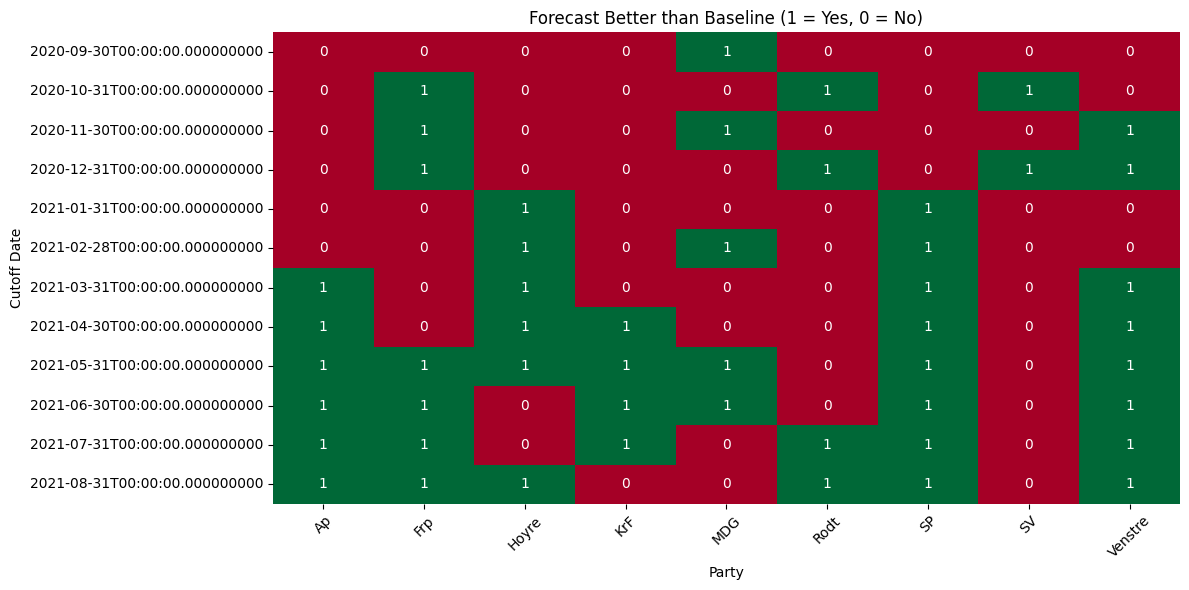

In [714]:
heatmap_data = df_party_errors.pivot(
    index="cutoff", columns="party", values="better_than_baseline_relative"
).astype(int)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="RdYlGn", cbar=False)
plt.title("Forecast Better than Baseline (1 = Yes, 0 = No)")
plt.xlabel("Party")
plt.ylabel("Cutoff Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [715]:
df_party_errors.loc[df_party_errors["party"] == "SV"]

,cutoff,party,steps,last_pop,model_est,actual_election_result,error_forecast,error_baseline,relative_error_forecast,relative_error_baseline,better_than_baseline,better_than_baseline_relative
3,2020-09-30,SV,13,7.8,10.383779,7.6,2.783779,0.2,0.366287,0.026316,False,False
12,2020-10-31,SV,12,7.0,7.580723,7.6,0.019277,0.6,0.002537,0.078947,True,True
21,2020-11-30,SV,11,7.2,6.437108,7.6,1.162892,0.4,0.153012,0.052632,False,False
30,2020-12-31,SV,10,7.5,7.268062,7.6,0.331938,0.1,0.043676,0.013158,False,True
39,2021-01-31,SV,9,7.1,9.584398,7.6,1.984398,0.5,0.261105,0.065789,False,False
48,2021-02-28,SV,8,7.4,9.566185,7.6,1.966185,0.2,0.258709,0.026316,False,False
57,2021-03-31,SV,7,7.8,9.180081,7.6,1.580081,0.2,0.207905,0.026316,False,False
66,2021-04-30,SV,6,8.0,9.480706,7.6,1.880706,0.4,0.247461,0.052632,False,False
75,2021-05-31,SV,5,8.0,9.722914,7.6,2.122914,0.4,0.279331,0.052632,False,False
84,2021-06-30,SV,4,7.8,9.384181,7.6,1.784181,0.2,0.234761,0.026316,False,False


In [716]:
forecast_df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
2021-08-31,23.189369,19.813621,10.865980,9.137392,13.191244,3.924302,4.348212,5.991831,5.041623
2021-09-30,22.396914,19.465840,11.264811,10.010546,14.112111,3.161076,4.775560,5.900872,4.871118


In [717]:
y_true

array([26.3, 20.4, 11.6,  7.6, 13.5,  3.8,  4.6,  3.9,  4.7])

In [718]:
last_actual_value

Ap         24.0
Hoyre      20.1
Frp        10.3
SV          8.8
SP         14.1
KrF         3.6
Venstre     4.1
MDG         5.5
Rodt        5.2
Name: 2021-08-31 00:00:00, dtype: float64